<a href="https://colab.research.google.com/github/joheras/PollenChallenge/blob/master/PollenChallenge.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Pollen challenge

We first download the dataset

In [1]:
!wget https://www.dropbox.com/s/3aqsypyc0bopch5/pollen.zip?dl=1 -O pollen.zip
!unzip pollen.zip

Se han truncado las últimas 5000 líneas del flujo de salida.
  inflating: pollen/train/3/20190404114512_OBJ_38_1136_250.png  
  inflating: pollen/train/3/20190404114516_OBJ_28_1222_247.png  
  inflating: pollen/train/3/20190404114522_OBJ_0_540_899.png  
  inflating: pollen/train/3/20190404114522_OBJ_11_433_633.png  
  inflating: pollen/train/3/20190404114522_OBJ_27_779_227.png  
  inflating: pollen/train/3/20190404114522_OBJ_38_827_66.png  
  inflating: pollen/train/3/20190404114527_OBJ_2_117_874.png  
  inflating: pollen/train/3/20190404114527_OBJ_39_722_145.png  
  inflating: pollen/train/3/20190404114527_OBJ_9_89_786.png  
  inflating: pollen/train/3/20190404114531_OBJ_0_493_873.png  
  inflating: pollen/train/3/20190404114531_OBJ_19_475_471.png  
  inflating: pollen/train/3/20190404114531_OBJ_24_1094_460.png  
  inflating: pollen/train/3/20190404114531_OBJ_28_996_406.png  
  inflating: pollen/train/3/20190404114531_OBJ_46_798_72.png  
  inflating: pollen/train/3/20190404114531_OBJ_

Load the fastai library.

In [2]:
seed = 42

# python RNG
import random
random.seed(seed)

# pytorch RNGs
import torch
torch.manual_seed(seed)
torch.backends.cudnn.deterministic = True
if torch.cuda.is_available(): torch.cuda.manual_seed_all(seed)

# numpy RNG
import numpy as np
np.random.seed(seed)

In [3]:
from fastai.vision import *
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="torch.nn.functional")

In [4]:
dataset = 'pollen'

We apply some data augmentation techniques, and load the dataset.

In [5]:
data=ImageDataBunch.from_folder(dataset,valid_pct=0.2,
        ds_tfms=get_transforms(), size=84,bs=32,seed=42).normalize(imagenet_stats)

We define three modes for training the models. 

In [6]:
def learn_with_model(model):
  learn = cnn_learner(data, model, metrics=[accuracy,FBeta(average='weighted',beta=1)], callback_fns=[partial(callbacks.tracker.EarlyStoppingCallback, min_delta=0.01, patience=3)])
  learn.fit_one_cycle(2)
  learn.unfreeze()
  learn.lr_find()
  lr=learn.recorder.lrs[np.argmin(learn.recorder.losses)]
  if lr<1e-05:
    lr=1e-03
  learn.fit_one_cycle(20,max_lr=slice(lr/100,lr),callbacks=[callbacks.tracker.SaveModelCallback(learn, every='improvement', monitor='accuracy', name='best')])
  return learn

In [7]:
def learn_with_model_imbalanced(model):
  learn = cnn_learner(data, model, metrics=[accuracy,FBeta(average='weighted',beta=1)], callback_fns=[partial(callbacks.tracker.EarlyStoppingCallback, min_delta=0.01, patience=5)])
  weights = [724.0/1156, 724.0/774,724.0/8816,1.0]
  class_weights=torch.FloatTensor(weights).cuda()
  learn.crit = nn.CrossEntropyLoss(weight=class_weights)
  learn.fit_one_cycle(2)
  learn.unfreeze()
  learn.lr_find()
  lr=learn.recorder.lrs[np.argmin(learn.recorder.losses)]
  if lr<1e-05:
    lr=1e-03
  learn.fit_one_cycle(20,max_lr=slice(lr/100,lr),callbacks=[callbacks.tracker.SaveModelCallback(learn, every='improvement', monitor='accuracy', name='best')])
  return learn



In [9]:
def learn_with_model_labelsmoothing(model):
  learn = cnn_learner(data, model, metrics=[accuracy,FBeta(average='weighted',beta=1)], loss_func=LabelSmoothingCrossEntropy(), callback_fns=[partial(callbacks.tracker.EarlyStoppingCallback, min_delta=0.01, patience=3)])
  learn.fit_one_cycle(2)
  learn.unfreeze()
  learn.lr_find()
  lr=learn.recorder.lrs[np.argmin(learn.recorder.losses)]
  if lr<1e-05:
    lr=1e-03
  learn.fit_one_cycle(20,max_lr=slice(lr/100,lr),callbacks=[callbacks.tracker.SaveModelCallback(learn, every='improvement', monitor='accuracy', name='best')])
  return learn

We study several backbones. 

# Resnet 34

## Normal training

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.676592,0.505018,0.827494,0.831660,00:37
1,0.445874,0.375854,0.870510,0.868427,00:37


epoch,train_loss,valid_loss,accuracy,f_beta,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.386005,0.322289,0.890466,0.890294,00:42
1,0.301088,0.271887,0.909534,0.908299,00:42
2,0.264116,0.242739,0.925055,0.924426,00:43
3,0.241431,0.258282,0.920621,0.915972,00:43
4,0.251171,0.289424,0.892683,0.898018,00:42
5,0.214652,0.262860,0.915299,0.917335,00:42
6,0.192630,0.221987,0.933038,0.932850,00:42
7,0.185064,0.211055,0.941907,0.941302,00:42
8,0.163738,0.206504,0.936142,0.936646,00:42
9,0.145817,0.216448,0.929933,0.930678,00:42


Better model found at epoch 0 with accuracy value: 0.8904656171798706.
Better model found at epoch 1 with accuracy value: 0.9095343947410583.
Better model found at epoch 2 with accuracy value: 0.9250554442405701.
Better model found at epoch 6 with accuracy value: 0.9330376982688904.
Better model found at epoch 7 with accuracy value: 0.9419068694114685.
Better model found at epoch 10 with accuracy value: 0.949002206325531.
Epoch 11: early stopping


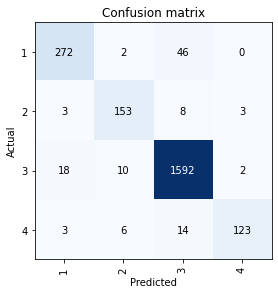

In [10]:
learnResnet34 = learn_with_model(models.resnet34)
interp = ClassificationInterpretation.from_learner(learnResnet34)
interp.plot_confusion_matrix()

## Weighted loss

epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.644649,0.519995,0.820399,0.821592,00:36
1,0.445391,0.378601,0.863415,0.861380,00:36


epoch,train_loss,valid_loss,accuracy,f_beta,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.381070,0.306165,0.895344,0.892827,00:43
1,0.304448,0.262213,0.917073,0.915752,00:42
2,0.299191,0.248343,0.923282,0.922916,00:42
3,0.248956,0.236191,0.936585,0.935707,00:42
4,0.224631,0.230439,0.940133,0.939396,00:42
5,0.224403,0.190709,0.946341,0.945143,00:42
6,0.198002,0.241769,0.926829,0.928340,00:42
7,0.181003,0.211960,0.941907,0.941767,00:42
8,0.168501,0.203505,0.947228,0.946495,00:42
9,0.164769,0.222434,0.938359,0.935864,00:42


Better model found at epoch 0 with accuracy value: 0.8953436613082886.
Better model found at epoch 1 with accuracy value: 0.9170731902122498.
Better model found at epoch 2 with accuracy value: 0.9232816100120544.
Better model found at epoch 3 with accuracy value: 0.9365853667259216.
Better model found at epoch 4 with accuracy value: 0.9401330351829529.
Better model found at epoch 5 with accuracy value: 0.9463414549827576.
Better model found at epoch 8 with accuracy value: 0.9472283720970154.
Epoch 11: early stopping


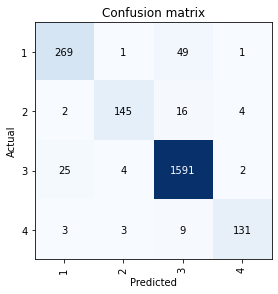

In [11]:
learnResnet34_im = learn_with_model_imbalanced(models.resnet34)
interp = ClassificationInterpretation.from_learner(learnResnet34_im)
interp.plot_confusion_matrix()

## LabelSmoothing

epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.902294,0.721307,0.821729,0.820973,00:36
1,0.691138,0.633820,0.861197,0.856898,00:36


epoch,train_loss,valid_loss,accuracy,f_beta,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.649698,0.577229,0.895344,0.893635,00:42
1,0.579809,0.538694,0.917517,0.916805,00:42
2,0.543613,0.520757,0.927273,0.926568,00:42
3,0.546468,0.513752,0.932151,0.932023,00:42
4,0.508829,0.489995,0.939690,0.938888,00:42
5,0.499143,0.484181,0.943681,0.943196,00:42
6,0.502911,0.481437,0.940133,0.940215,00:42
7,0.488734,0.482819,0.946341,0.945391,00:42


Better model found at epoch 0 with accuracy value: 0.8953436613082886.
Better model found at epoch 1 with accuracy value: 0.9175166487693787.
Better model found at epoch 2 with accuracy value: 0.9272727370262146.
Better model found at epoch 3 with accuracy value: 0.9321507811546326.
Better model found at epoch 4 with accuracy value: 0.939689576625824.
Better model found at epoch 5 with accuracy value: 0.9436807036399841.
Better model found at epoch 7 with accuracy value: 0.9463414549827576.
Epoch 8: early stopping


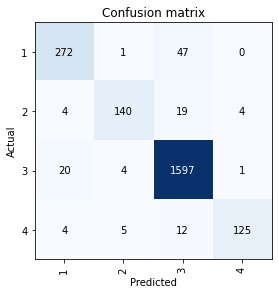

In [12]:
learnResnet34_ls = learn_with_model_labelsmoothing(models.resnet34)
interp = ClassificationInterpretation.from_learner(learnResnet34_ls)
interp.plot_confusion_matrix()

# Resnet 50

## Normal training

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/checkpoints/resnet50-19c8e357.pth


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.633541,0.499575,0.826164,0.829546,00:46
1,0.406793,0.344722,0.878049,0.877521,00:44


epoch,train_loss,valid_loss,accuracy,f_beta,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.337552,0.297638,0.895344,0.895047,01:04
1,0.282262,0.243526,0.917073,0.916249,01:04
2,0.230143,0.221175,0.933925,0.932325,01:04
3,0.244571,0.201590,0.941907,0.940365,01:04
4,0.225151,0.192338,0.943681,0.941814,01:04
5,0.189585,0.184962,0.949002,0.948555,01:04
6,0.206670,0.173090,0.948115,0.947497,01:04
7,0.179031,0.183348,0.943681,0.942858,01:04
8,0.156168,0.224207,0.933925,0.935301,01:04
9,0.121446,0.225728,0.936142,0.937050,01:04


Better model found at epoch 0 with accuracy value: 0.8953436613082886.
Better model found at epoch 1 with accuracy value: 0.9170731902122498.
Better model found at epoch 2 with accuracy value: 0.9339246153831482.
Better model found at epoch 3 with accuracy value: 0.9419068694114685.
Better model found at epoch 4 with accuracy value: 0.9436807036399841.
Better model found at epoch 5 with accuracy value: 0.949002206325531.
Epoch 10: early stopping


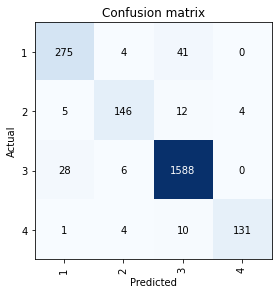

In [13]:
learnResnet50 = learn_with_model(models.resnet50)
interp = ClassificationInterpretation.from_learner(learnResnet50)
interp.plot_confusion_matrix()

## Weighted loss

epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.630286,0.570668,0.813747,0.822338,00:45
1,0.388135,0.373196,0.870067,0.872212,00:45


epoch,train_loss,valid_loss,accuracy,f_beta,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.343706,0.293490,0.903769,0.903628,01:04
1,0.269365,0.246254,0.919290,0.918635,01:04
2,0.254605,0.233371,0.930820,0.930251,01:04
3,0.260978,0.221399,0.930820,0.928991,01:04
4,0.247075,0.204198,0.935698,0.935541,01:04
5,0.204436,0.186835,0.946785,0.946096,01:04
6,0.197836,0.198849,0.945898,0.944690,01:04
7,0.178943,0.171896,0.952993,0.952820,01:04
8,0.142164,0.194129,0.946785,0.945920,01:04
9,0.147550,0.200880,0.939690,0.940027,01:04


Better model found at epoch 0 with accuracy value: 0.9037693738937378.
Better model found at epoch 0 with accuracy value: 0.9037693738937378.
Better model found at epoch 1 with accuracy value: 0.9192904829978943.
Better model found at epoch 1 with accuracy value: 0.9192904829978943.
Better model found at epoch 2 with accuracy value: 0.9308204054832458.
Better model found at epoch 2 with accuracy value: 0.9308204054832458.
Better model found at epoch 4 with accuracy value: 0.9356984496116638.
Better model found at epoch 4 with accuracy value: 0.9356984496116638.
Better model found at epoch 5 with accuracy value: 0.9467849135398865.
Better model found at epoch 5 with accuracy value: 0.9467849135398865.
Better model found at epoch 7 with accuracy value: 0.9529933333396912.
Better model found at epoch 7 with accuracy value: 0.9529933333396912.
Epoch 13: early stopping
Epoch 13: early stopping


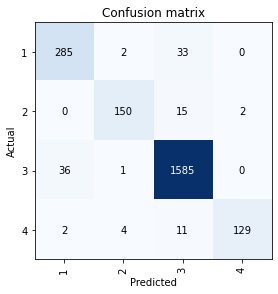

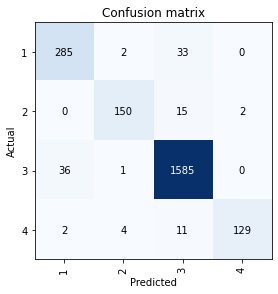

In [14]:
learnResnet50_im = learn_with_model_imbalanced(models.resnet50)
interp = ClassificationInterpretation.from_learner(learnResnet50_im)
interp.plot_confusion_matrix()

## Labelsmoothing

epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.803061,0.684856,0.854989,0.852404,00:44
1,0.671714,0.613638,0.877605,0.874489,00:44


epoch,train_loss,valid_loss,accuracy,f_beta,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.606254,0.560201,0.905543,0.903747,01:06
1,0.567384,0.547698,0.918404,0.918762,01:08
2,0.524556,0.500404,0.933481,0.932415,01:05
3,0.525111,0.475157,0.947228,0.946158,01:05
4,0.508664,0.475972,0.946341,0.944931,01:05
5,0.489242,0.482104,0.940576,0.940694,01:05
6,0.480393,0.483155,0.942794,0.941901,01:04


Better model found at epoch 0 with accuracy value: 0.9055432081222534.
LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Better model found at epoch 0 with accuracy value: 0.9055432081222534.
Better model found at epoch 1 with accuracy value: 0.9184035658836365.
Better model found at epoch 1 with accuracy value: 0.9184035658836365.
Better model found at epoch 2 with accuracy value: 0.9334811568260193.
Better model found at epoch 2 with accuracy value: 0.9334811568260193.
Better model found at epoch 3 with accuracy value: 0.9472283720970154.
Better model found at epoch 3 with accuracy value: 0.9472283720970154.
Epoch 7: early stopping
Epoch 7: early stopping


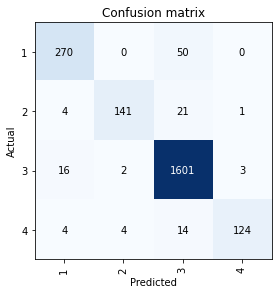

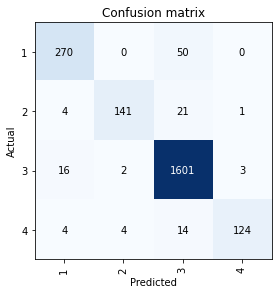

In [15]:
learnResnet50_ls = learn_with_model_labelsmoothing(models.resnet50)
interp = ClassificationInterpretation.from_learner(learnResnet50_ls)
interp.plot_confusion_matrix()

# Resnet 101

## Normal training

Downloading: "https://download.pytorch.org/models/resnet101-5d3b4d8f.pth" to /root/.cache/torch/checkpoints/resnet101-5d3b4d8f.pth
Downloading: "https://download.pytorch.org/models/resnet101-5d3b4d8f.pth" to /root/.cache/torch/checkpoints/resnet101-5d3b4d8f.pth


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.597135,1.040338,0.845676,0.846711,01:15
1,0.382743,0.807632,0.858093,0.862020,01:15


epoch,train_loss,valid_loss,accuracy,f_beta,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.327607,0.371879,0.900222,0.901004,01:48
1,0.261434,0.260519,0.916186,0.916502,01:48
2,0.237624,0.297453,0.911752,0.912576,01:48
3,0.247457,0.309639,0.922838,0.921316,01:48
4,0.244572,0.293101,0.887805,0.895390,01:48
5,0.227467,0.224329,0.929933,0.926062,01:48
6,0.221981,0.228038,0.929933,0.931264,01:48
7,0.172905,0.256381,0.912639,0.915502,01:49
8,0.162307,0.218991,0.948115,0.947026,01:49
9,0.137248,0.190224,0.947672,0.946765,01:48


Better model found at epoch 0 with accuracy value: 0.9002217054367065.
Better model found at epoch 0 with accuracy value: 0.9002217054367065.
Better model found at epoch 1 with accuracy value: 0.9161862730979919.
Better model found at epoch 1 with accuracy value: 0.9161862730979919.
Better model found at epoch 3 with accuracy value: 0.9228381514549255.
Better model found at epoch 3 with accuracy value: 0.9228381514549255.
Better model found at epoch 5 with accuracy value: 0.929933488368988.
Better model found at epoch 5 with accuracy value: 0.929933488368988.
Better model found at epoch 8 with accuracy value: 0.9481152892112732.
Better model found at epoch 8 with accuracy value: 0.9481152892112732.
Better model found at epoch 11 with accuracy value: 0.9512194991111755.
Better model found at epoch 11 with accuracy value: 0.9512194991111755.
Epoch 15: early stopping
Epoch 15: early stopping


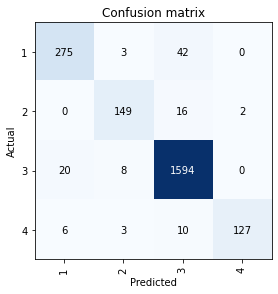

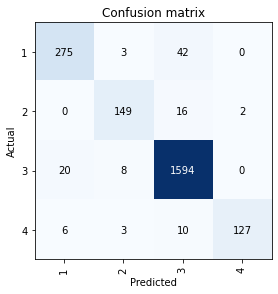

In [16]:
learnResnet101 = learn_with_model_imbalanced(models.resnet101)
interp = ClassificationInterpretation.from_learner(learnResnet101)
interp.plot_confusion_matrix()

## Weighted loss


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.585513,0.690703,0.861641,0.860381,01:15
1,0.390278,0.623106,0.902882,0.901802,01:15


epoch,train_loss,valid_loss,accuracy,f_beta,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.302047,0.630056,0.908204,0.906251,01:49
1,0.262568,0.291399,0.924612,0.924433,01:49
2,0.240874,0.284554,0.914412,0.915143,01:48
3,0.267436,0.249044,0.924612,0.921097,01:49
4,0.262009,0.240289,0.932594,0.932148,01:49
5,0.227229,0.312930,0.898448,0.902990,01:49
6,0.206320,0.179526,0.951219,0.950256,01:49
7,0.182793,0.237638,0.923282,0.923858,01:49
8,0.196381,0.267170,0.925055,0.927149,01:49
9,0.141342,0.205257,0.945898,0.945363,01:49


Better model found at epoch 0 with accuracy value: 0.9082040190696716.
Better model found at epoch 0 with accuracy value: 0.9082040190696716.
Better model found at epoch 1 with accuracy value: 0.9246119856834412.
Better model found at epoch 1 with accuracy value: 0.9246119856834412.
Better model found at epoch 4 with accuracy value: 0.9325942397117615.
Better model found at epoch 4 with accuracy value: 0.9325942397117615.
Better model found at epoch 6 with accuracy value: 0.9512194991111755.
Better model found at epoch 6 with accuracy value: 0.9512194991111755.
Epoch 12: early stopping
Epoch 12: early stopping


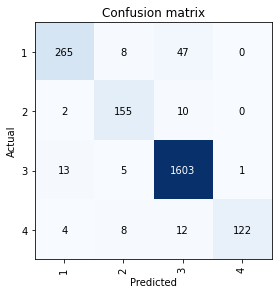

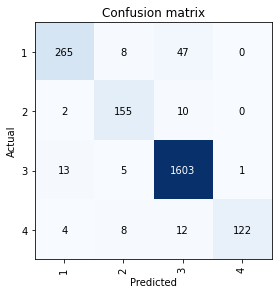

In [17]:
learnResnet101_im = learn_with_model_imbalanced(models.resnet101)
interp = ClassificationInterpretation.from_learner(learnResnet101_im)
interp.plot_confusion_matrix()

## LabelSmoothing

epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.820411,1.405632,0.832816,0.836424,01:15
1,0.623579,1.035424,0.884701,0.883223,01:15


epoch,train_loss,valid_loss,accuracy,f_beta,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.600466,0.789593,0.901552,0.900725,01:49
1,0.532775,0.523252,0.928603,0.926966,01:49
2,0.539394,0.522563,0.929490,0.929833,01:49
3,0.528863,0.502441,0.933481,0.933281,01:48
4,0.523931,0.526914,0.919734,0.913541,01:48
5,0.502584,0.487955,0.939246,0.937136,01:49
6,0.491016,0.499615,0.929933,0.931171,01:49
7,0.493843,0.474381,0.942794,0.943191,01:49
8,0.476633,0.466991,0.949889,0.949906,01:49
9,0.457317,0.458495,0.952550,0.951922,01:49


Better model found at epoch 0 with accuracy value: 0.9015520811080933.
Better model found at epoch 0 with accuracy value: 0.9015520811080933.
Better model found at epoch 1 with accuracy value: 0.9286031126976013.
Better model found at epoch 1 with accuracy value: 0.9286031126976013.
Better model found at epoch 2 with accuracy value: 0.9294900298118591.
Better model found at epoch 2 with accuracy value: 0.9294900298118591.
Better model found at epoch 3 with accuracy value: 0.9334811568260193.
Better model found at epoch 3 with accuracy value: 0.9334811568260193.
Better model found at epoch 5 with accuracy value: 0.9392461180686951.
Better model found at epoch 5 with accuracy value: 0.9392461180686951.
Better model found at epoch 7 with accuracy value: 0.9427937865257263.
Better model found at epoch 7 with accuracy value: 0.9427937865257263.
Better model found at epoch 8 with accuracy value: 0.9498891234397888.
Better model found at epoch 8 with accuracy value: 0.9498891234397888.
Better

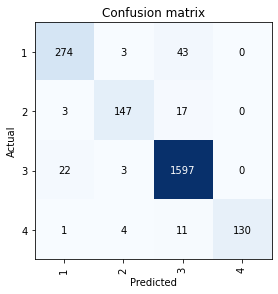

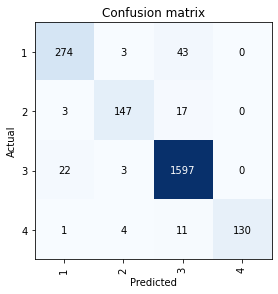

In [18]:
learnResnet101_ls = learn_with_model_labelsmoothing(models.resnet101)
interp = ClassificationInterpretation.from_learner(learnResnet101_ls)
interp.plot_confusion_matrix()

# Densenet 121

## Normal training

Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/checkpoints/densenet121-a639ec97.pth
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/checkpoints/densenet121-a639ec97.pth


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.537325,0.336565,0.893570,0.889718,01:04
1,0.350907,0.283941,0.911308,0.907335,01:01


epoch,train_loss,valid_loss,accuracy,f_beta,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.281632,0.256224,0.914856,0.911452,01:17
1,0.306185,0.243095,0.923282,0.923169,01:17
2,0.263240,0.217074,0.928603,0.927435,01:17
3,0.248188,0.210299,0.934812,0.933127,01:17
4,0.223979,0.215485,0.936142,0.935735,01:16
5,0.193119,0.200221,0.942794,0.941913,01:17
6,0.188162,0.185916,0.948115,0.947511,01:17
7,0.179274,0.204072,0.944568,0.944074,01:17
8,0.135820,0.198842,0.944124,0.944230,01:17
9,0.104936,0.194763,0.951219,0.950782,01:17


Better model found at epoch 0 with accuracy value: 0.9148558974266052.
Better model found at epoch 0 with accuracy value: 0.9148558974266052.
Better model found at epoch 1 with accuracy value: 0.9232816100120544.
Better model found at epoch 1 with accuracy value: 0.9232816100120544.
Better model found at epoch 2 with accuracy value: 0.9286031126976013.
Better model found at epoch 2 with accuracy value: 0.9286031126976013.
Better model found at epoch 3 with accuracy value: 0.934811532497406.
Better model found at epoch 3 with accuracy value: 0.934811532497406.
Better model found at epoch 4 with accuracy value: 0.9361419081687927.
Better model found at epoch 4 with accuracy value: 0.9361419081687927.
Better model found at epoch 5 with accuracy value: 0.9427937865257263.
Better model found at epoch 5 with accuracy value: 0.9427937865257263.
Better model found at epoch 6 with accuracy value: 0.9481152892112732.
Better model found at epoch 6 with accuracy value: 0.9481152892112732.
Better m

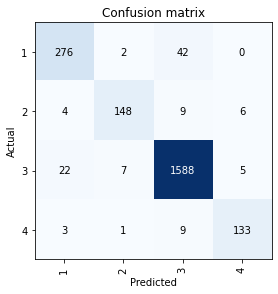

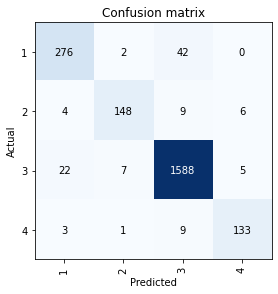

In [19]:
learnDensenet121 = learn_with_model(models.densenet121)
interp = ClassificationInterpretation.from_learner(learnDensenet121)
interp.plot_confusion_matrix()

## Weighted loss

epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.514268,0.344585,0.893126,0.891279,01:00
1,0.326853,0.274202,0.913526,0.911942,01:01


epoch,train_loss,valid_loss,accuracy,f_beta,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.296106,0.253569,0.917960,0.915250,01:16
1,0.259061,0.227478,0.929047,0.927585,01:17
2,0.266779,0.233968,0.932151,0.931457,01:17
3,0.233820,0.221554,0.931264,0.931082,01:17
4,0.225386,0.201320,0.937029,0.936852,01:17
5,0.180181,0.207783,0.940576,0.939425,01:17
6,0.179885,0.214288,0.944568,0.942923,01:17
7,0.175226,0.196871,0.948115,0.947009,01:17
8,0.151393,0.199830,0.950776,0.950084,01:17
9,0.137169,0.195673,0.945898,0.945552,01:17


Better model found at epoch 0 with accuracy value: 0.9179601073265076.
Better model found at epoch 0 with accuracy value: 0.9179601073265076.
Better model found at epoch 1 with accuracy value: 0.9290465712547302.
Better model found at epoch 1 with accuracy value: 0.9290465712547302.
Better model found at epoch 2 with accuracy value: 0.9321507811546326.
Better model found at epoch 2 with accuracy value: 0.9321507811546326.
Better model found at epoch 4 with accuracy value: 0.9370288252830505.
Better model found at epoch 4 with accuracy value: 0.9370288252830505.
Better model found at epoch 5 with accuracy value: 0.9405764937400818.
Better model found at epoch 5 with accuracy value: 0.9405764937400818.
Better model found at epoch 6 with accuracy value: 0.9445676207542419.
Better model found at epoch 6 with accuracy value: 0.9445676207542419.
Better model found at epoch 7 with accuracy value: 0.9481152892112732.
Better model found at epoch 7 with accuracy value: 0.9481152892112732.
Better

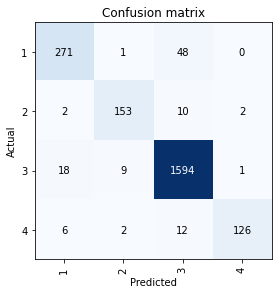

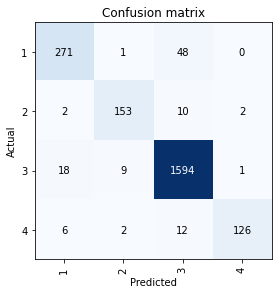

In [20]:
learnDensenet121_im = learn_with_model_imbalanced(models.densenet121)
interp = ClassificationInterpretation.from_learner(learnDensenet121_im)
interp.plot_confusion_matrix()

## LabelSmoothing

epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.803508,0.617538,0.890022,0.887169,01:01
1,0.602966,0.555130,0.906874,0.904178,01:01


epoch,train_loss,valid_loss,accuracy,f_beta,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.597126,0.540977,0.915299,0.912284,01:17
1,0.572465,0.524530,0.925942,0.923598,01:17
2,0.538424,0.507453,0.937029,0.935978,01:17
3,0.516006,0.503262,0.935698,0.935222,01:18
4,0.508571,0.491955,0.939246,0.938538,01:18
5,0.489474,0.472245,0.950333,0.949466,01:18
6,0.481665,0.478388,0.945455,0.945515,01:17
7,0.463470,0.461760,0.950776,0.950391,01:17
8,0.458493,0.471795,0.948115,0.947671,01:18
9,0.438322,0.460517,0.956098,0.955308,01:18


Better model found at epoch 0 with accuracy value: 0.9152993559837341.
Better model found at epoch 0 with accuracy value: 0.9152993559837341.
Better model found at epoch 1 with accuracy value: 0.9259423613548279.
Better model found at epoch 1 with accuracy value: 0.9259423613548279.
Better model found at epoch 2 with accuracy value: 0.9370288252830505.
Better model found at epoch 2 with accuracy value: 0.9370288252830505.
Better model found at epoch 4 with accuracy value: 0.9392461180686951.
Better model found at epoch 4 with accuracy value: 0.9392461180686951.
Better model found at epoch 5 with accuracy value: 0.9503325819969177.
Better model found at epoch 5 with accuracy value: 0.9503325819969177.
Better model found at epoch 7 with accuracy value: 0.9507760405540466.
Better model found at epoch 7 with accuracy value: 0.9507760405540466.
Better model found at epoch 9 with accuracy value: 0.9560975432395935.
Better model found at epoch 9 with accuracy value: 0.9560975432395935.
Epoch 

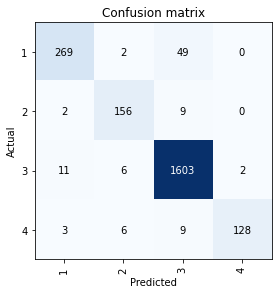

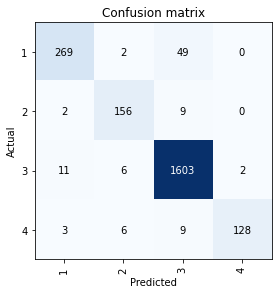

In [21]:
learnDensenet121_ls = learn_with_model_labelsmoothing(models.densenet121)
interp = ClassificationInterpretation.from_learner(learnDensenet121_ls)
interp.plot_confusion_matrix()

# Efficientnet B1

## Install additional libraries

In [22]:
!pip install efficientnet-pytorch

  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.6.3-cp36-none-any.whl size=12422 sha256=35dfca9e2c68bb8da37494f1a5bd28e14777c2fb454280b90476c4bc2feb157b
  Stored in directory: /root/.cache/pip/wheels/42/1e/a9/2a578ba9ad04e776e80bf0f70d8a7f4c29ec0718b92d8f6ccd
Successfully built efficientnet-pytorch
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.6.3-cp36-none-any.whl size=12422 sha256=35dfca9e2c68bb8da37494f1a5bd28e14777c2fb454280b90476c4bc2feb157b
  Stored in directory: /root/.cache/pip/wheels/42/1e/a9/2a578ba9ad04e776e80bf0f70d8a7f4c29ec0718b92d8f6ccd
Successfully built efficientnet-pytorch


In [61]:
import shutil
from fastai.vision import *
from fastai.vision import *
import os
import shutil
import glob
import random
from fastai.utils.mem import *
from fastai.vision.models import efficientnet

## Normal training

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b1-f1951068.pth" to /root/.cache/torch/checkpoints/efficientnet-b1-f1951068.pth
Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b1-f1951068.pth" to /root/.cache/torch/checkpoints/efficientnet-b1-f1951068.pth



Loaded pretrained weights for efficientnet-b1

Loaded pretrained weights for efficientnet-b1


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.343028,0.330930,0.911752,0.910754,01:10
1,0.263670,0.322645,0.926386,0.923739,01:08
2,0.213878,0.328704,0.915299,0.917645,01:08
3,0.202112,0.290320,0.932151,0.930237,01:08
4,0.191507,0.366667,0.901552,0.893826,01:08
5,0.201985,0.301365,0.930377,0.926873,01:08
6,0.180828,0.227882,0.935255,0.935954,01:08
7,0.141427,0.233734,0.932151,0.927854,01:08
8,0.149882,0.192690,0.944568,0.944970,01:08
9,0.149421,0.197350,0.938359,0.939070,01:08


Better model found at epoch 0 with accuracy value: 0.9117516875267029.
Better model found at epoch 0 with accuracy value: 0.9117516875267029.
Better model found at epoch 1 with accuracy value: 0.9263858199119568.
Better model found at epoch 1 with accuracy value: 0.9263858199119568.
Better model found at epoch 3 with accuracy value: 0.9321507811546326.
Better model found at epoch 3 with accuracy value: 0.9321507811546326.
Better model found at epoch 6 with accuracy value: 0.9352549910545349.
Better model found at epoch 6 with accuracy value: 0.9352549910545349.
Better model found at epoch 8 with accuracy value: 0.9445676207542419.
Better model found at epoch 8 with accuracy value: 0.9445676207542419.
Better model found at epoch 11 with accuracy value: 0.9498891234397888.
Better model found at epoch 11 with accuracy value: 0.9498891234397888.
Better model found at epoch 14 with accuracy value: 0.9534367918968201.
Better model found at epoch 14 with accuracy value: 0.9534367918968201.
Be

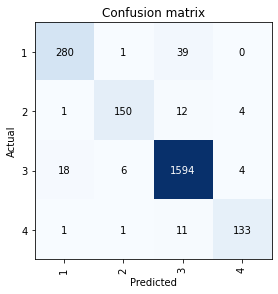

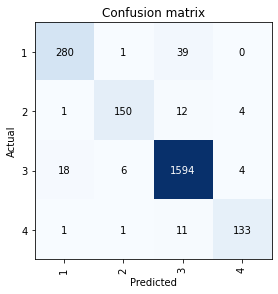

In [24]:
learnB1_n = Learner(data, models.efficientnet.EfficientNetB1(data), wd=1e-3, 
               bn_wd=False, true_wd=True, loss_func=nn.CrossEntropyLoss(),
               metrics=[accuracy,FBeta(average='weighted',beta=1)], callback_fns=[partial(callbacks.tracker.EarlyStoppingCallback, min_delta=0.01, patience=5),
                                                                               partial(callbacks.tracker.SaveModelCallback, every='improvement', monitor='accuracy', name='best')])

learnB1_n.fit_fc(20,1e-03)
interp = ClassificationInterpretation.from_learner(learnB1_n)
interp.plot_confusion_matrix()

## Weighted loss

Loaded pretrained weights for efficientnet-b1


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.577706,0.542481,0.932594,0.929693,01:08
1,0.520218,0.513726,0.947228,0.946318,01:08
2,0.501226,0.508763,0.938359,0.938669,01:08
3,0.484385,0.508736,0.941020,0.938332,01:08
4,0.463251,0.496846,0.948559,0.946900,01:07
5,0.477861,0.497739,0.943681,0.941672,01:08
6,0.471334,0.485289,0.948559,0.947179,01:07
7,0.450171,0.482580,0.950776,0.949624,01:08
8,0.439289,0.453020,0.954324,0.953482,01:08
9,0.463425,0.460946,0.952993,0.952088,01:08


Better model found at epoch 0 with accuracy value: 0.9325942397117615.
Better model found at epoch 1 with accuracy value: 0.9472283720970154.
Better model found at epoch 4 with accuracy value: 0.9485587477684021.
Better model found at epoch 7 with accuracy value: 0.9507760405540466.
Better model found at epoch 8 with accuracy value: 0.9543237090110779.
Epoch 14: early stopping


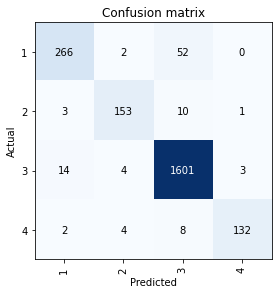

In [25]:
learnB1_im = Learner(data, models.efficientnet.EfficientNetB1(data), wd=1e-3, 
               bn_wd=False, true_wd=True, loss_func=LabelSmoothingCrossEntropy(),
               metrics=[accuracy,FBeta(average='weighted',beta=1)], callback_fns=[partial(callbacks.tracker.EarlyStoppingCallback, min_delta=0.01, patience=5),
                                                                               partial(callbacks.tracker.SaveModelCallback, every='improvement', monitor='accuracy', name='best')])

weights = [724.0/1156, 724.0/774,724.0/8816,1.0]
class_weights=torch.FloatTensor(weights).cuda()
learnB1_im.crit = nn.CrossEntropyLoss(weight=class_weights)
learnB1_im.fit_fc(20,1e-03)
interp = ClassificationInterpretation.from_learner(learnB1_im)
interp.plot_confusion_matrix()

## LabelSmoothing

Loaded pretrained weights for efficientnet-b1


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.572953,0.544083,0.930377,0.928232,01:08
1,0.515013,0.516140,0.935255,0.932707,01:08
2,0.502938,0.480976,0.946341,0.945828,01:08
3,0.487521,0.555179,0.933481,0.929576,01:07
4,0.473474,0.464971,0.953880,0.952924,01:07
5,0.460379,0.488205,0.943681,0.943027,01:08
6,0.462628,0.505536,0.937029,0.937538,01:07
7,0.445679,0.478168,0.947672,0.945832,01:07
8,0.442542,0.458633,0.956098,0.955651,01:08
9,0.449109,0.466769,0.955654,0.954792,01:08


Better model found at epoch 0 with accuracy value: 0.9303769469261169.
Better model found at epoch 1 with accuracy value: 0.9352549910545349.
Better model found at epoch 2 with accuracy value: 0.9463414549827576.
Better model found at epoch 4 with accuracy value: 0.953880250453949.
Better model found at epoch 8 with accuracy value: 0.9560975432395935.
Epoch 10: early stopping


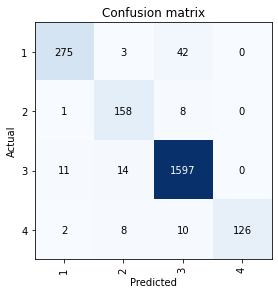

In [26]:
learnB1_ls = Learner(data, models.efficientnet.EfficientNetB1(data), wd=1e-3, 
               bn_wd=False, true_wd=True, loss_func=LabelSmoothingCrossEntropy(),
               metrics=[accuracy,FBeta(average='weighted',beta=1)], callback_fns=[partial(callbacks.tracker.EarlyStoppingCallback, min_delta=0.01, patience=5),
                                                                               partial(callbacks.tracker.SaveModelCallback, every='improvement', monitor='accuracy', name='best')])

learnB1_ls.fit_fc(20,1e-03)
interp = ClassificationInterpretation.from_learner(learnB1_ls)
interp.plot_confusion_matrix()

# EfficientNet B2

## Normal training

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b2-8bb594d6.pth" to /root/.cache/torch/checkpoints/efficientnet-b2-8bb594d6.pth



Loaded pretrained weights for efficientnet-b2


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.353834,0.548744,0.809756,0.828910,01:11
1,0.270802,0.259539,0.941463,0.940476,01:08
2,0.235409,0.313681,0.939246,0.936969,01:08
3,0.217307,0.228303,0.946341,0.946034,01:08
4,0.183978,0.280066,0.909534,0.912916,01:08
5,0.190400,0.173347,0.953437,0.953019,01:08
6,0.162623,0.254587,0.913526,0.916972,01:08
7,0.159018,0.206194,0.939246,0.939689,01:09
8,0.151103,0.190690,0.946341,0.945942,01:08
9,0.149490,0.209969,0.950776,0.949498,01:08


Better model found at epoch 0 with accuracy value: 0.8097561001777649.
Better model found at epoch 1 with accuracy value: 0.9414634108543396.
Better model found at epoch 3 with accuracy value: 0.9463414549827576.
Better model found at epoch 5 with accuracy value: 0.9534367918968201.
Epoch 11: early stopping


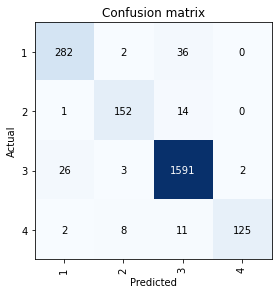

In [27]:
learnB2 = Learner(data, models.efficientnet.EfficientNetB2(data), wd=1e-3, 
               bn_wd=False, true_wd=True, loss_func=nn.CrossEntropyLoss(),
               metrics=[accuracy,FBeta(average='weighted',beta=1)], callback_fns=[partial(callbacks.tracker.EarlyStoppingCallback, min_delta=0.01, patience=5),
                                                                               partial(callbacks.tracker.SaveModelCallback, every='improvement', monitor='accuracy', name='best')])

learnB2.fit_fc(20,1e-03)
interp = ClassificationInterpretation.from_learner(learnB2)
interp.plot_confusion_matrix()

## Weighted loss

Loaded pretrained weights for efficientnet-b2


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.579338,0.555845,0.922395,0.918881,01:09
1,0.544322,0.520690,0.931264,0.927577,01:09
2,0.515478,0.588832,0.878049,0.886632,01:09
3,0.478375,0.496498,0.943681,0.943395,01:09
4,0.476413,0.510367,0.929490,0.930591,01:09
5,0.473285,0.484372,0.940576,0.940493,01:09
6,0.465069,0.471863,0.943237,0.941555,01:10
7,0.451109,0.466794,0.952106,0.951335,01:09
8,0.451269,0.495388,0.937472,0.935263,01:09
9,0.435689,0.496966,0.940133,0.937584,01:09


Better model found at epoch 0 with accuracy value: 0.9223946928977966.
Better model found at epoch 1 with accuracy value: 0.9312638640403748.
Better model found at epoch 3 with accuracy value: 0.9436807036399841.
Better model found at epoch 7 with accuracy value: 0.9521064162254333.
Better model found at epoch 10 with accuracy value: 0.9552106261253357.
Epoch 12: early stopping


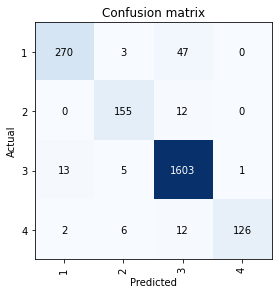

In [28]:
learnB2_im = Learner(data, models.efficientnet.EfficientNetB2(data), wd=1e-3, 
               bn_wd=False, true_wd=True, loss_func=LabelSmoothingCrossEntropy(),
               metrics=[accuracy,FBeta(average='weighted',beta=1)], callback_fns=[partial(callbacks.tracker.EarlyStoppingCallback, min_delta=0.01, patience=5),
                                                                               partial(callbacks.tracker.SaveModelCallback, every='improvement', monitor='accuracy', name='best')])

weights = [724.0/1156, 724.0/774,724.0/8816,1.0]
class_weights=torch.FloatTensor(weights).cuda()
learnB2_im.crit = nn.CrossEntropyLoss(weight=class_weights)
learnB2_im.fit_fc(20,1e-03)
interp = ClassificationInterpretation.from_learner(learnB2_im)
interp.plot_confusion_matrix()

## LabelSmoothing

Loaded pretrained weights for efficientnet-b2


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.584178,0.638246,0.907317,0.901118,01:09
1,0.521032,0.533776,0.930377,0.929106,01:10
2,0.516190,0.529310,0.936585,0.935565,01:10
3,0.488652,0.496523,0.938359,0.936343,01:10
4,0.486081,0.502941,0.944568,0.943770,01:09
5,0.471874,0.497925,0.933925,0.934932,01:10
6,0.454149,0.467204,0.952106,0.951252,01:09
7,0.459983,0.471972,0.947672,0.948030,01:10
8,0.433756,0.479274,0.942350,0.942926,01:09
9,0.434491,0.471284,0.949446,0.949642,01:09


Better model found at epoch 0 with accuracy value: 0.9073171019554138.
Better model found at epoch 1 with accuracy value: 0.9303769469261169.
Better model found at epoch 2 with accuracy value: 0.9365853667259216.
Better model found at epoch 3 with accuracy value: 0.9383592009544373.
Better model found at epoch 4 with accuracy value: 0.9445676207542419.
Better model found at epoch 6 with accuracy value: 0.9521064162254333.
Epoch 12: early stopping


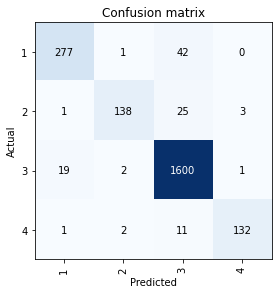

In [29]:
learnB2_ls = Learner(data, models.efficientnet.EfficientNetB2(data), wd=1e-3, 
               bn_wd=False, true_wd=True, loss_func=LabelSmoothingCrossEntropy(),
               metrics=[accuracy,FBeta(average='weighted',beta=1)], callback_fns=[partial(callbacks.tracker.EarlyStoppingCallback, min_delta=0.01, patience=5),
                                                                               partial(callbacks.tracker.SaveModelCallback, every='improvement', monitor='accuracy', name='best')])

learnB2_ls.fit_fc(20,1e-03)
interp = ClassificationInterpretation.from_learner(learnB2_ls)
interp.plot_confusion_matrix()

# EfficientNet B3

## Normal training

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b3-5fb5a3c3.pth" to /root/.cache/torch/checkpoints/efficientnet-b3-5fb5a3c3.pth



Loaded pretrained weights for efficientnet-b3


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.342179,0.435388,0.892239,0.891950,01:31
1,0.270247,0.863293,0.910865,0.905065,01:29
2,0.273243,0.399074,0.924612,0.919568,01:29
3,0.215125,0.278756,0.918404,0.920773,01:29
4,0.218244,0.309791,0.941463,0.941339,01:29
5,0.170996,0.224659,0.936585,0.936912,01:29
6,0.177514,0.229702,0.952993,0.951826,01:29
7,0.181449,0.292156,0.948115,0.946516,01:29
8,0.168843,0.179313,0.951219,0.950502,01:29
9,0.147267,0.199732,0.952993,0.951784,01:29


Better model found at epoch 0 with accuracy value: 0.8922394514083862.
Better model found at epoch 1 with accuracy value: 0.9108647704124451.
Better model found at epoch 2 with accuracy value: 0.9246119856834412.
Better model found at epoch 4 with accuracy value: 0.9414634108543396.
Better model found at epoch 6 with accuracy value: 0.9529933333396912.
Epoch 14: early stopping


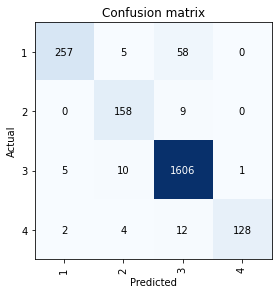

In [30]:
learnB3 = Learner(data, models.efficientnet.EfficientNetB3(data), wd=1e-3, 
               bn_wd=False, true_wd=True, loss_func=nn.CrossEntropyLoss(),
               metrics=[accuracy,FBeta(average='weighted',beta=1)], callback_fns=[partial(callbacks.tracker.EarlyStoppingCallback, min_delta=0.01, patience=5),
                                                                               partial(callbacks.tracker.SaveModelCallback, every='improvement', monitor='accuracy', name='best')])
learnB3.fit_fc(20,1e-03)
interp = ClassificationInterpretation.from_learner(learnB3)
interp.plot_confusion_matrix()

## Weighted loss

Loaded pretrained weights for efficientnet-b3


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.584321,0.565317,0.929933,0.928841,01:29
1,0.521442,0.657208,0.904656,0.907459,01:29
2,0.512076,0.526555,0.938359,0.936722,01:29
3,0.502592,0.486380,0.942350,0.942571,01:29
4,0.487666,1.386828,0.929933,0.925875,01:29
5,0.478293,0.612239,0.871397,0.881516,01:29
6,0.480215,0.561292,0.913969,0.917292,01:30
7,0.452611,0.466129,0.952106,0.952001,01:29
8,0.459313,0.472455,0.948559,0.947418,01:29
9,0.445816,0.470427,0.949889,0.948761,01:30


Better model found at epoch 0 with accuracy value: 0.929933488368988.
Better model found at epoch 2 with accuracy value: 0.9383592009544373.
Better model found at epoch 3 with accuracy value: 0.9423503279685974.
Better model found at epoch 7 with accuracy value: 0.9521064162254333.
Epoch 13: early stopping


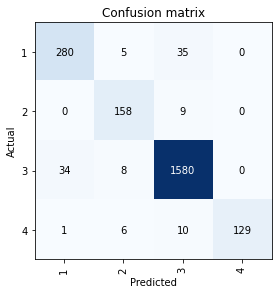

In [31]:
learnB3_im = Learner(data, models.efficientnet.EfficientNetB3(data), wd=1e-3, 
               bn_wd=False, true_wd=True, loss_func=LabelSmoothingCrossEntropy(),
               metrics=[accuracy,FBeta(average='weighted',beta=1)], callback_fns=[partial(callbacks.tracker.EarlyStoppingCallback, min_delta=0.01, patience=5),
                                                                               partial(callbacks.tracker.SaveModelCallback, every='improvement', monitor='accuracy', name='best')])

weights = [724.0/1156, 724.0/774,724.0/8816,1.0]
class_weights=torch.FloatTensor(weights).cuda()
learnB3_im.crit = nn.CrossEntropyLoss(weight=class_weights)
learnB3_im.fit_fc(20,1e-03)
interp = ClassificationInterpretation.from_learner(learnB3_im)
interp.plot_confusion_matrix()

## LabelSmoothing

Loaded pretrained weights for efficientnet-b3


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.583474,0.645478,0.880266,0.869096,01:30
1,0.528485,0.634754,0.905543,0.899279,01:30
2,0.516810,0.536619,0.939690,0.939546,01:30
3,0.487558,0.549114,0.910865,0.912644,01:29
4,0.464957,0.527228,0.931707,0.928291,01:31
5,0.467339,0.552601,0.921508,0.915074,01:30
6,0.457597,0.473312,0.946341,0.946027,01:30
7,0.448598,0.488225,0.950333,0.948954,01:30
8,0.452214,0.476678,0.946341,0.945626,01:30
9,0.455885,0.538750,0.913526,0.916638,01:30


Better model found at epoch 0 with accuracy value: 0.8802660703659058.
Better model found at epoch 1 with accuracy value: 0.9055432081222534.
Better model found at epoch 2 with accuracy value: 0.939689576625824.
Better model found at epoch 6 with accuracy value: 0.9463414549827576.
Better model found at epoch 7 with accuracy value: 0.9503325819969177.
Better model found at epoch 11 with accuracy value: 0.9560975432395935.
Better model found at epoch 12 with accuracy value: 0.9578713774681091.
Better model found at epoch 17 with accuracy value: 0.9592017531394958.
Better model found at epoch 18 with accuracy value: 0.9600886702537537.
Better model found at epoch 19 with accuracy value: 0.9605321288108826.


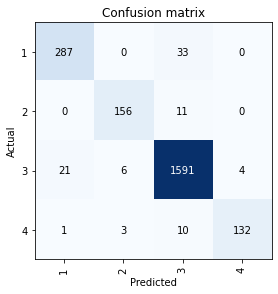

In [32]:
learnB3_ls = Learner(data, models.efficientnet.EfficientNetB3(data), wd=1e-3, 
               bn_wd=False, true_wd=True, loss_func=LabelSmoothingCrossEntropy(),
               metrics=[accuracy,FBeta(average='weighted',beta=1)], callback_fns=[partial(callbacks.tracker.EarlyStoppingCallback, min_delta=0.01, patience=5),
                                                                               partial(callbacks.tracker.SaveModelCallback, every='improvement', monitor='accuracy', name='best')])

learnB3_ls.fit_fc(20,1e-03)
interp = ClassificationInterpretation.from_learner(learnB3_ls)
interp.plot_confusion_matrix()

# EfficientNet B4

## Normal training

Loaded pretrained weights for efficientnet-b4


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.548945,0.601411,0.891796,0.893827,01:55
1,0.533266,0.520094,0.945455,0.944211,01:55
2,0.484384,0.541020,0.911308,0.914830,01:55
3,0.488394,0.514771,0.941907,0.939868,01:55
4,0.484147,0.490730,0.950776,0.949618,01:55
5,0.466125,0.516085,0.921064,0.923569,01:55
6,0.455446,0.494702,0.932151,0.933084,01:55
7,0.447153,0.466417,0.948115,0.947040,01:55
8,0.440849,0.461716,0.951219,0.950272,01:55
9,0.430261,0.484584,0.949002,0.947727,01:55


Better model found at epoch 0 with accuracy value: 0.8917959928512573.
Better model found at epoch 1 with accuracy value: 0.9454545378684998.
Better model found at epoch 4 with accuracy value: 0.9507760405540466.
Better model found at epoch 8 with accuracy value: 0.9512194991111755.
Epoch 13: early stopping


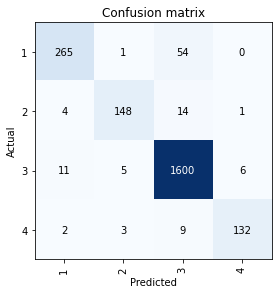

In [62]:
learnB4 = Learner(data, models.efficientnet.EfficientNetB4(data), wd=1e-3, 
               bn_wd=False, true_wd=True, loss_func=LabelSmoothingCrossEntropy(),
               metrics=[accuracy,FBeta(average='weighted',beta=1)], callback_fns=[partial(callbacks.tracker.EarlyStoppingCallback, min_delta=0.01, patience=5),
                                                                               partial(callbacks.tracker.SaveModelCallback, every='improvement', monitor='accuracy', name='best')])
learnB4.fit_fc(20,1e-03)
interp = ClassificationInterpretation.from_learner(learnB4)
interp.plot_confusion_matrix()

## Weighted loss

Loaded pretrained weights for efficientnet-b4


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.565862,0.573582,0.917517,0.916670,01:57
1,0.532943,0.531841,0.926386,0.922412,01:56
2,0.516230,0.607167,0.893570,0.900653,01:55
3,0.498028,0.482565,0.943681,0.943908,01:55
4,0.475210,0.472643,0.955654,0.954840,01:55
5,0.451314,0.489152,0.948559,0.947294,01:55
6,0.469812,0.493867,0.951219,0.950393,01:56
7,0.457261,0.466623,0.954324,0.953713,01:56
8,0.438964,0.478784,0.953437,0.952173,01:55
9,0.441287,0.471985,0.955211,0.954361,01:56


Better model found at epoch 0 with accuracy value: 0.9175166487693787.
Better model found at epoch 1 with accuracy value: 0.9263858199119568.
Better model found at epoch 3 with accuracy value: 0.9436807036399841.
Better model found at epoch 4 with accuracy value: 0.9556540846824646.
Epoch 13: early stopping


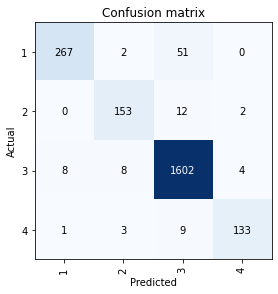

In [34]:
learnB4_im = Learner(data, models.efficientnet.EfficientNetB4(data), wd=1e-3, 
               bn_wd=False, true_wd=True, loss_func=LabelSmoothingCrossEntropy(),
               metrics=[accuracy,FBeta(average='weighted',beta=1)], callback_fns=[partial(callbacks.tracker.EarlyStoppingCallback, min_delta=0.01, patience=5),
                                                                               partial(callbacks.tracker.SaveModelCallback, every='improvement', monitor='accuracy', name='best')])

weights = [724.0/1156, 724.0/774,724.0/8816,1.0]
class_weights=torch.FloatTensor(weights).cuda()
learnB4_im.crit = nn.CrossEntropyLoss(weight=class_weights)
learnB4_im.fit_fc(20,1e-03)
interp = ClassificationInterpretation.from_learner(learnB4_im)
interp.plot_confusion_matrix()

## LabelSmoothing

Loaded pretrained weights for efficientnet-b3


epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.552987,0.595888,0.917960,0.913026,01:30
1,0.523879,0.681867,0.924169,0.918656,01:30
2,0.497691,0.602260,0.918847,0.912752,01:30
3,0.478976,0.527207,0.917073,0.918760,01:30
4,0.471712,0.611695,0.863858,0.875133,01:30
5,0.475130,0.487899,0.948559,0.947505,01:30
6,0.465534,0.529048,0.930377,0.930029,01:30
7,0.452724,0.470468,0.954324,0.953509,01:30
8,0.459395,0.495557,0.946341,0.945100,01:30
9,0.442502,0.472389,0.947672,0.945788,01:30


Better model found at epoch 0 with accuracy value: 0.9179601073265076.
Better model found at epoch 1 with accuracy value: 0.9241685271263123.
Better model found at epoch 5 with accuracy value: 0.9485587477684021.
Better model found at epoch 7 with accuracy value: 0.9543237090110779.
Epoch 13: early stopping


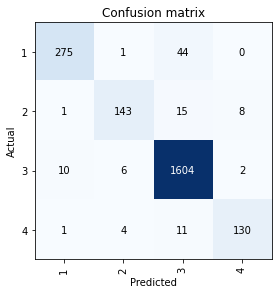

In [35]:
learnB4_ls = Learner(data, models.efficientnet.EfficientNetB3(data), wd=1e-3, 
               bn_wd=False, true_wd=True, loss_func=LabelSmoothingCrossEntropy(),
               metrics=[accuracy,FBeta(average='weighted',beta=1)], callback_fns=[partial(callbacks.tracker.EarlyStoppingCallback, min_delta=0.01, patience=5),
                                                                               partial(callbacks.tracker.SaveModelCallback, every='improvement', monitor='accuracy', name='best')])

learnB4_ls.fit_fc(20,1e-03)
interp = ClassificationInterpretation.from_learner(learnB4_ls)
interp.plot_confusion_matrix()

# Test set

In [36]:
!wget https://www.dropbox.com/s/2k2tj2iwjikeiu9/test.zip?dl=1 -O test.zip

--2020-07-08 12:51:38--  https://www.dropbox.com/s/2k2tj2iwjikeiu9/test.zip?dl=1
Resolving www.dropbox.com (www.dropbox.com)... 162.125.82.1, 2620:100:6032:1::a27d:5201
Connecting to www.dropbox.com (www.dropbox.com)|162.125.82.1|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/dl/2k2tj2iwjikeiu9/test.zip [following]
--2020-07-08 12:51:38--  https://www.dropbox.com/s/dl/2k2tj2iwjikeiu9/test.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc465a18521e5e0a34a15c179dca.dl.dropboxusercontent.com/cd/0/get/A7KR4gNWg_sey1nMjqGcH7B_7kyfxAqjfRk9DwXC8zHzZMHTij30Jh39So3a7Kr3nl1PW04Mxf5-gFm-zouOurdKf8uv8N33xIMfoPPP86p1oTtDqzlcU37AeYJvVVH-KOU/file?dl=1# [following]
--2020-07-08 12:51:38--  https://uc465a18521e5e0a34a15c179dca.dl.dropboxusercontent.com/cd/0/get/A7KR4gNWg_sey1nMjqGcH7B_7kyfxAqjfRk9DwXC8zHzZMHTij30Jh39So3a7Kr3nl1PW04Mxf5-gFm-zouOurdKf8uv8N33xIMfoPPP86p1oTtDqzlcU37Ae

In [37]:
!unzip test.zip

Archive:  test.zip
   creating: test/
   creating: test/images/
  inflating: test/images/20190402163258_OBJ_0_855_351.png  
  inflating: test/images/20190402163953_OBJ_2_685_452.png  
  inflating: test/images/20190402164018_OBJ_3_762_481.png  
  inflating: test/images/20190402164058_OBJ_1_613_524.png  
  inflating: test/images/20190402164113_OBJ_2_337_489.png  
  inflating: test/images/20190402165159_OBJ_0_1164_216.png  
  inflating: test/images/20190402165310_OBJ_4_610_96.png  
  inflating: test/images/20190402165451_OBJ_8_711_66.png  
  inflating: test/images/20190402165536_OBJ_0_207_750.png  
  inflating: test/images/20190402165608_OBJ_3_482_279.png  
  inflating: test/images/20190402165615_OBJ_3_688_506.png  
  inflating: test/images/20190402165615_OBJ_5_987_198.png  
  inflating: test/images/20190402165615_OBJ_6_783_62.png  
  inflating: test/images/20190402165648_OBJ_5_855_465.png  
  inflating: test/images/20190402165700_OBJ_1_947_201.png  
  inflating: test/images/2019040216570

## Model ensemble

In [38]:
def ensemble_predition(models,test_path,test_img):
    img = open_image(test_path + test_img)
    
    sum_pred = None
    for m in models:
      if sum_pred is None:
        sum_pred = (m.predict(img))[2]
      else:
        sum_pred += (m.predict(img))[2]
    
    #ensemble average
    prediction = sum_pred / len(models)
    
    #prediction results
    predicted_label = torch.argmax(prediction).item()
    return predicted_label+1

In [39]:
submission_data = []

In [40]:
test_path = 'test/images/'

In [41]:
models = [learnResnet34, learnResnet50_im, learnResnet101_ls, learnDensenet121_ls, learnB1, learnB2_im, learnB3_ls,learnB4_ls]

In [42]:
ensemble_predition(models,test_path,'20190404114628_OBJ_36_978_332.png')

3

In [43]:
from tqdm import tqdm 
with tqdm(total=len(os.listdir(test_path))) as pbar:       
    #test all test images
    for img in os.listdir(test_path):
        label = ensemble_predition(models, test_path, img)
        new_np_array = np.array([])
        submission_data.append([img, label])
        pbar.update(1)



100%|██████████| 1991/1991 [06:10<00:00,  5.37it/s]


In [44]:
subObj =[{'Filename': filename, "Class": str(cl)} for filename,cl in submission_data]

In [45]:
import json

In [46]:
with open('result.json', 'w') as outfile:
    json.dump(subObj,outfile)

## Ensemble for validation data

In [47]:
def ensemble_preditionImg(models,img):
    sum_pred = None
    for m in models:
      if sum_pred is None:
        sum_pred = (m.predict(img))[2]
      else:
        sum_pred += (m.predict(img))[2]
    
    #ensemble average
    prediction = sum_pred / len(models)
    
    #prediction results
    predicted_label = torch.argmax(prediction).item()
    return predicted_label

Taking all the models

In [48]:
res = []
labels = []
with tqdm(total=len(data.valid_ds)) as pbar:  
  for img in data.valid_ds:
    label = ensemble_preditionImg(models, img[0])
    res.append(label)
    labels.append(img[1])
    pbar.update(1)

100%|██████████| 2255/2255 [06:58<00:00,  5.39it/s]


In [49]:
labels = [c.data for c in labels]

In [50]:
import numpy as np
from sklearn.metrics import accuracy_score, f1_score

In [51]:
accuracy_score(np.array(labels),np.array(res))

0.9614190687361419

In [53]:
f1_score(np.array(labels),np.array(res),average='weighted')

0.9608134195250018

Taking the 3 best models.

In [63]:
models2 = [learnResnet50_im, learnB2_im, learnB3_ls]

In [64]:
res = []
labels = []
with tqdm(total=len(data.valid_ds)) as pbar:  
  for img in data.valid_ds:
    label = ensemble_preditionImg(models2, img[0])
    res.append(label)
    labels.append(img[1])
    pbar.update(1)

100%|██████████| 2255/2255 [03:08<00:00, 11.94it/s]


In [65]:
labels = [c.data for c in labels]

In [66]:
accuracy_score(np.array(labels),np.array(res))

0.9623059866962306

In [67]:
f1_score(np.array(labels),np.array(res),average='weighted')

0.9617972861795178